#**Preprocessing Images Rice Dataset**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font, Alignment
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from matplotlib import font_manager
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import psutil
import zipfile


import numpy as np
import tensorflow as tf
import random as rd

**Detail of Python Notebook in Google Colab**

In [ ]:
!nvidia-smi
import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Sun Aug 24 13:16:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Initialize Setting**

In [ ]:
root_dir = '/content/drive/MyDrive/projectPlant/'

**SEED**

In [ ]:
seeds = [42]
print(seeds)

[42]


**Font Setting**

In [ ]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


**คำอธิบาย**

แบ่ง Data แบบ Fixed Train และ Validation ในอัตราส่วน 70:30

สำหรับ Test มี Dataset แยกอยู่แล้ว

In [ ]:
rice_title = 'Rice Dataset'
rice_dataset_name = 'riceDataset'
rice_dataset_dir = root_dir + rice_dataset_name

In [ ]:
rice_train_dir = rice_dataset_dir + '/train_smp'
rice_test_dir = rice_dataset_dir + '/pred_img'

In [ ]:
zip_filename = 'rice_dataset_raw.zip'
zip_dir = rice_dataset_dir + '/' + zip_filename
target_folders = [rice_train_dir, rice_test_dir]
with zipfile.ZipFile(zip_dir, "w", zipfile.ZIP_DEFLATED) as zipf:
    for folder in target_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, os.path.dirname(folder)))
print(f'Zip folder complete at {zip_dir}')

Zip folder complete at /content/drive/MyDrive/projectPlant/riceDataset/rice_dataset_raw.zip


In [ ]:
rice_img_dir = root_dir + 'Extra2/' + rice_dataset_name
rice_sample_img_dir = rice_img_dir + '/SampleImages'
rice_excel_dir = root_dir + 'DatasetSetting/' + rice_dataset_name + '/'

os.makedirs(rice_img_dir, exist_ok=True)
os.makedirs(rice_sample_img_dir, exist_ok=True)
os.makedirs(rice_excel_dir, exist_ok=True)

**Recheck Path and Verify Images**

In [ ]:
print("Total directories and rice train images: \n")
walk_through_dir(rice_train_dir)

Total directories and rice train images: 

There are 0 directories and 500 images in '/content/drive/MyDrive/projectPlant/riceDataset/train_smp'.


In [ ]:
print("Total directories and rice test images: \n")
walk_through_dir(rice_test_dir)

Total directories and rice test images: 

There are 0 directories and 60 images in '/content/drive/MyDrive/projectPlant/riceDataset/pred_img'.


In [ ]:
print("Verifying rice train images: \n")
verify_images(rice_train_dir)

Verifying rice train images: 

Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_100.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_16.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_17.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_18.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_19.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_21.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_20.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_22.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_23.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_24.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_smp/1_25.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/train_sm

In [ ]:
print("Verifying rice test images: \n")
verify_images(rice_test_dir)

Verifying rice test images: 

Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_1.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_5.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_7.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_2.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_3.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_4.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/1_6.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/2_1.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/2_10.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/2_11.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/2_12.jpg Done
Checking: /content/drive/MyDrive/projectPlant/riceDataset/pred_img/2_13.jpg Done
Checki

**Match Label**

In [ ]:
labels_mapping = mapping(rice_dataset_name)
print(labels_mapping)

{'1': 'Rice Stackburn', '2': 'Rice Leaf Smut', '4': 'Rice Leaf Scald', '8': 'Rice White Tip', '25': 'Bacterial Leaf Streak'}


**Convert to dataframe**

In [ ]:
base_rice_train_df = to_dataframe(rice_train_dir, mode='multi', condition=False, labels_mapping=labels_mapping)
base_rice_test_df = to_dataframe(rice_test_dir, mode='multi', condition=False, labels_mapping=labels_mapping)

Total images: 500
Total classes: 5
Total images: 60
Total classes: 5


In [ ]:
print("Base Rice Train Dataframe \n")
base_rice_train_df

Base Rice Train Dataframe 



,Filepath,Label
0,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
1,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
2,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
3,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
4,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
...,...,...
495,/content/drive/MyDrive/projectPlant/riceDatase...,Bacterial Leaf Streak
496,/content/drive/MyDrive/projectPlant/riceDatase...,Bacterial Leaf Streak
497,/content/drive/MyDrive/projectPlant/riceDatase...,Bacterial Leaf Streak
498,/content/drive/MyDrive/projectPlant/riceDatase...,Bacterial Leaf Streak


In [ ]:
print("Base Rice Test Dataframe \n")
base_rice_test_df

Base Rice Test Dataframe 



,Filepath,Label
0,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
1,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
2,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
3,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
4,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
5,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
6,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
7,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut
8,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut
9,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut


**Description table**

In [ ]:
rice_images_df = pd.concat([base_rice_train_df, base_rice_test_df], axis=0).reset_index(drop=True)
rice_images_df

,Filepath,Label
0,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
1,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
2,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
3,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
4,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
...,...,...
555,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip
556,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip
557,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip
558,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip


In [ ]:
print(f"{rice_title} description table \n")
rice_summary_df = rice_images_df.groupby('Label').size().reset_index(name='Count')
rice_summary_df

Rice Dataset description table 



,Label,Count
0,Bacterial Leaf Streak,108
1,Rice Leaf Scald,115
2,Rice Leaf Smut,115
3,Rice Stackburn,107
4,Rice White Tip,115


##**Visualize Images**

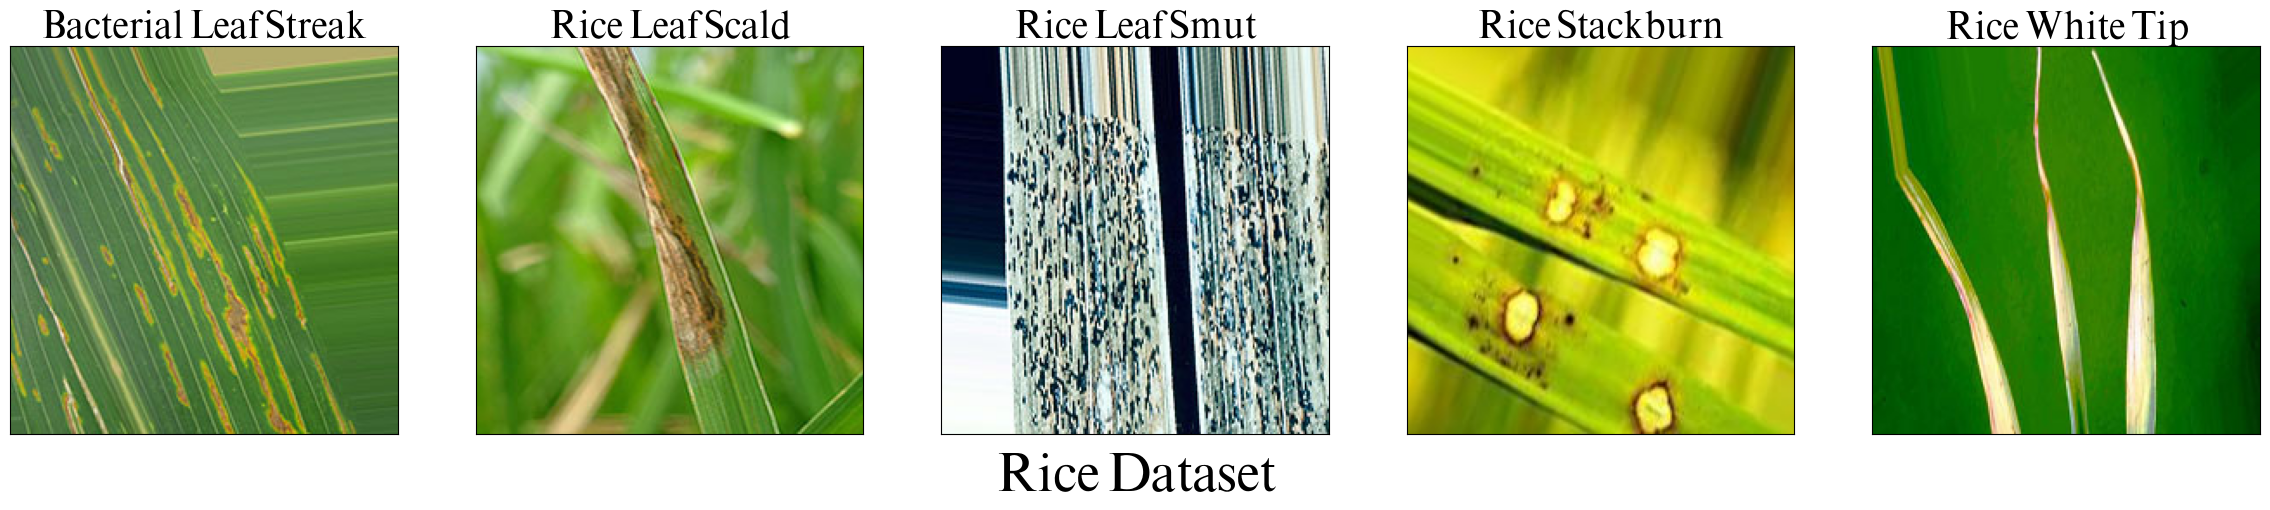

In [ ]:
visualize_images_by_class(df=rice_images_df, nrows=1, ncols=5, title=rice_title, fontsize=25,
                          fontname="OPTITimes-Roman", image_width=5, image_height=5, paths=rice_sample_img_dir)

##**Allocate Dataset**

In [ ]:
# วนลูปสำหรับแต่ละ SEED
for seed in seeds:
    print(f"Running experiment with SEED={seed}")
    np.random.seed(seed)
    tf.random.set_seed(seed)
    rd.seed(seed)

    # แบ่งข้อมูล Train (70%) และ Validation (30%)
    train_data, val_data = train_test_split(
        base_rice_train_df,
        test_size=0.3,  # 30% สำหรับ Validation
        random_state=seed
    )

    # เก็บ Original_Index
    train_data['Original_Index'] = train_data.index
    val_data['Original_Index'] = val_data.index

    # สร้าง DataFrame สำหรับ Train และ Validation
    data = {
        'Train_Index': train_data['Original_Index'].tolist(),
        'Train_Paths': train_data['Filepath'].tolist(),
        'Validation_Index': val_data['Original_Index'].tolist(),
        'Validation_Paths': val_data['Filepath'].tolist(),
    }

    # เติมข้อมูลให้มีความยาวเท่ากัน
    max_length = max(
        len(data['Train_Paths']),
        len(data['Validation_Paths'])
    )

    data['Train_Index'] += [''] * (max_length - len(data['Train_Index']))
    data['Train_Paths'] += [''] * (max_length - len(data['Train_Paths']))
    data['Validation_Index'] += [''] * (max_length - len(data['Validation_Index']))
    data['Validation_Paths'] += [''] * (max_length - len(data['Validation_Paths']))

    # แปลงข้อมูลเป็น DataFrame
    df = pd.DataFrame(data)

    # ตั้งชื่อไฟล์ที่บันทึก
    file_name = f'{rice_excel_dir}split_data_seed_{seed}.xlsx'

    # บันทึกข้อมูลลง Excel
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        df.to_excel(writer, index=False, sheet_name='Split-Data')

        # ปรับขนาดคอลัมน์
        workbook = writer.book
        sheet = workbook['Split-Data']

        for col in sheet.columns:
            max_length = 0
            column = col[0].column_letter  # Get the column letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = max_length + 2
            sheet.column_dimensions[column].width = adjusted_width

        # จัดรูปแบบ header
        header = sheet[1]
        for cell in header:
            cell.alignment = Alignment(horizontal="center", vertical="center")
            cell.font = Font(bold=True)

    print(f"Data split and saved to {file_name}")
    print("--------------------------------------------------")

Running experiment with SEED=42
Data split and saved to /content/drive/MyDrive/projectPlant/DatasetSetting/riceDataset/split_data_seed_42.xlsx
--------------------------------------------------


##**Augmentation Samples Images**

In [ ]:
train_data

,Filepath,Label,Original_Index
5,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,5
116,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,116
45,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,45
16,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,16
462,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,462
...,...,...,...
106,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,106
270,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,270
348,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip,348
435,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,435


In [ ]:
val_data

,Filepath,Label,Original_Index
361,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip,361
73,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,73
374,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip,374
155,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,155
104,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut,104
...,...,...,...
266,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,266
23,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn,23
222,/content/drive/MyDrive/projectPlant/riceDatase...,Bacterial Leaf Streak,222
261,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald,261


In [ ]:
SEED=seeds[-1]
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

train_images = train_generator.flow_from_dataframe(
    dataframe = train_data,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

Found 350 validated image filenames belonging to 5 classes.


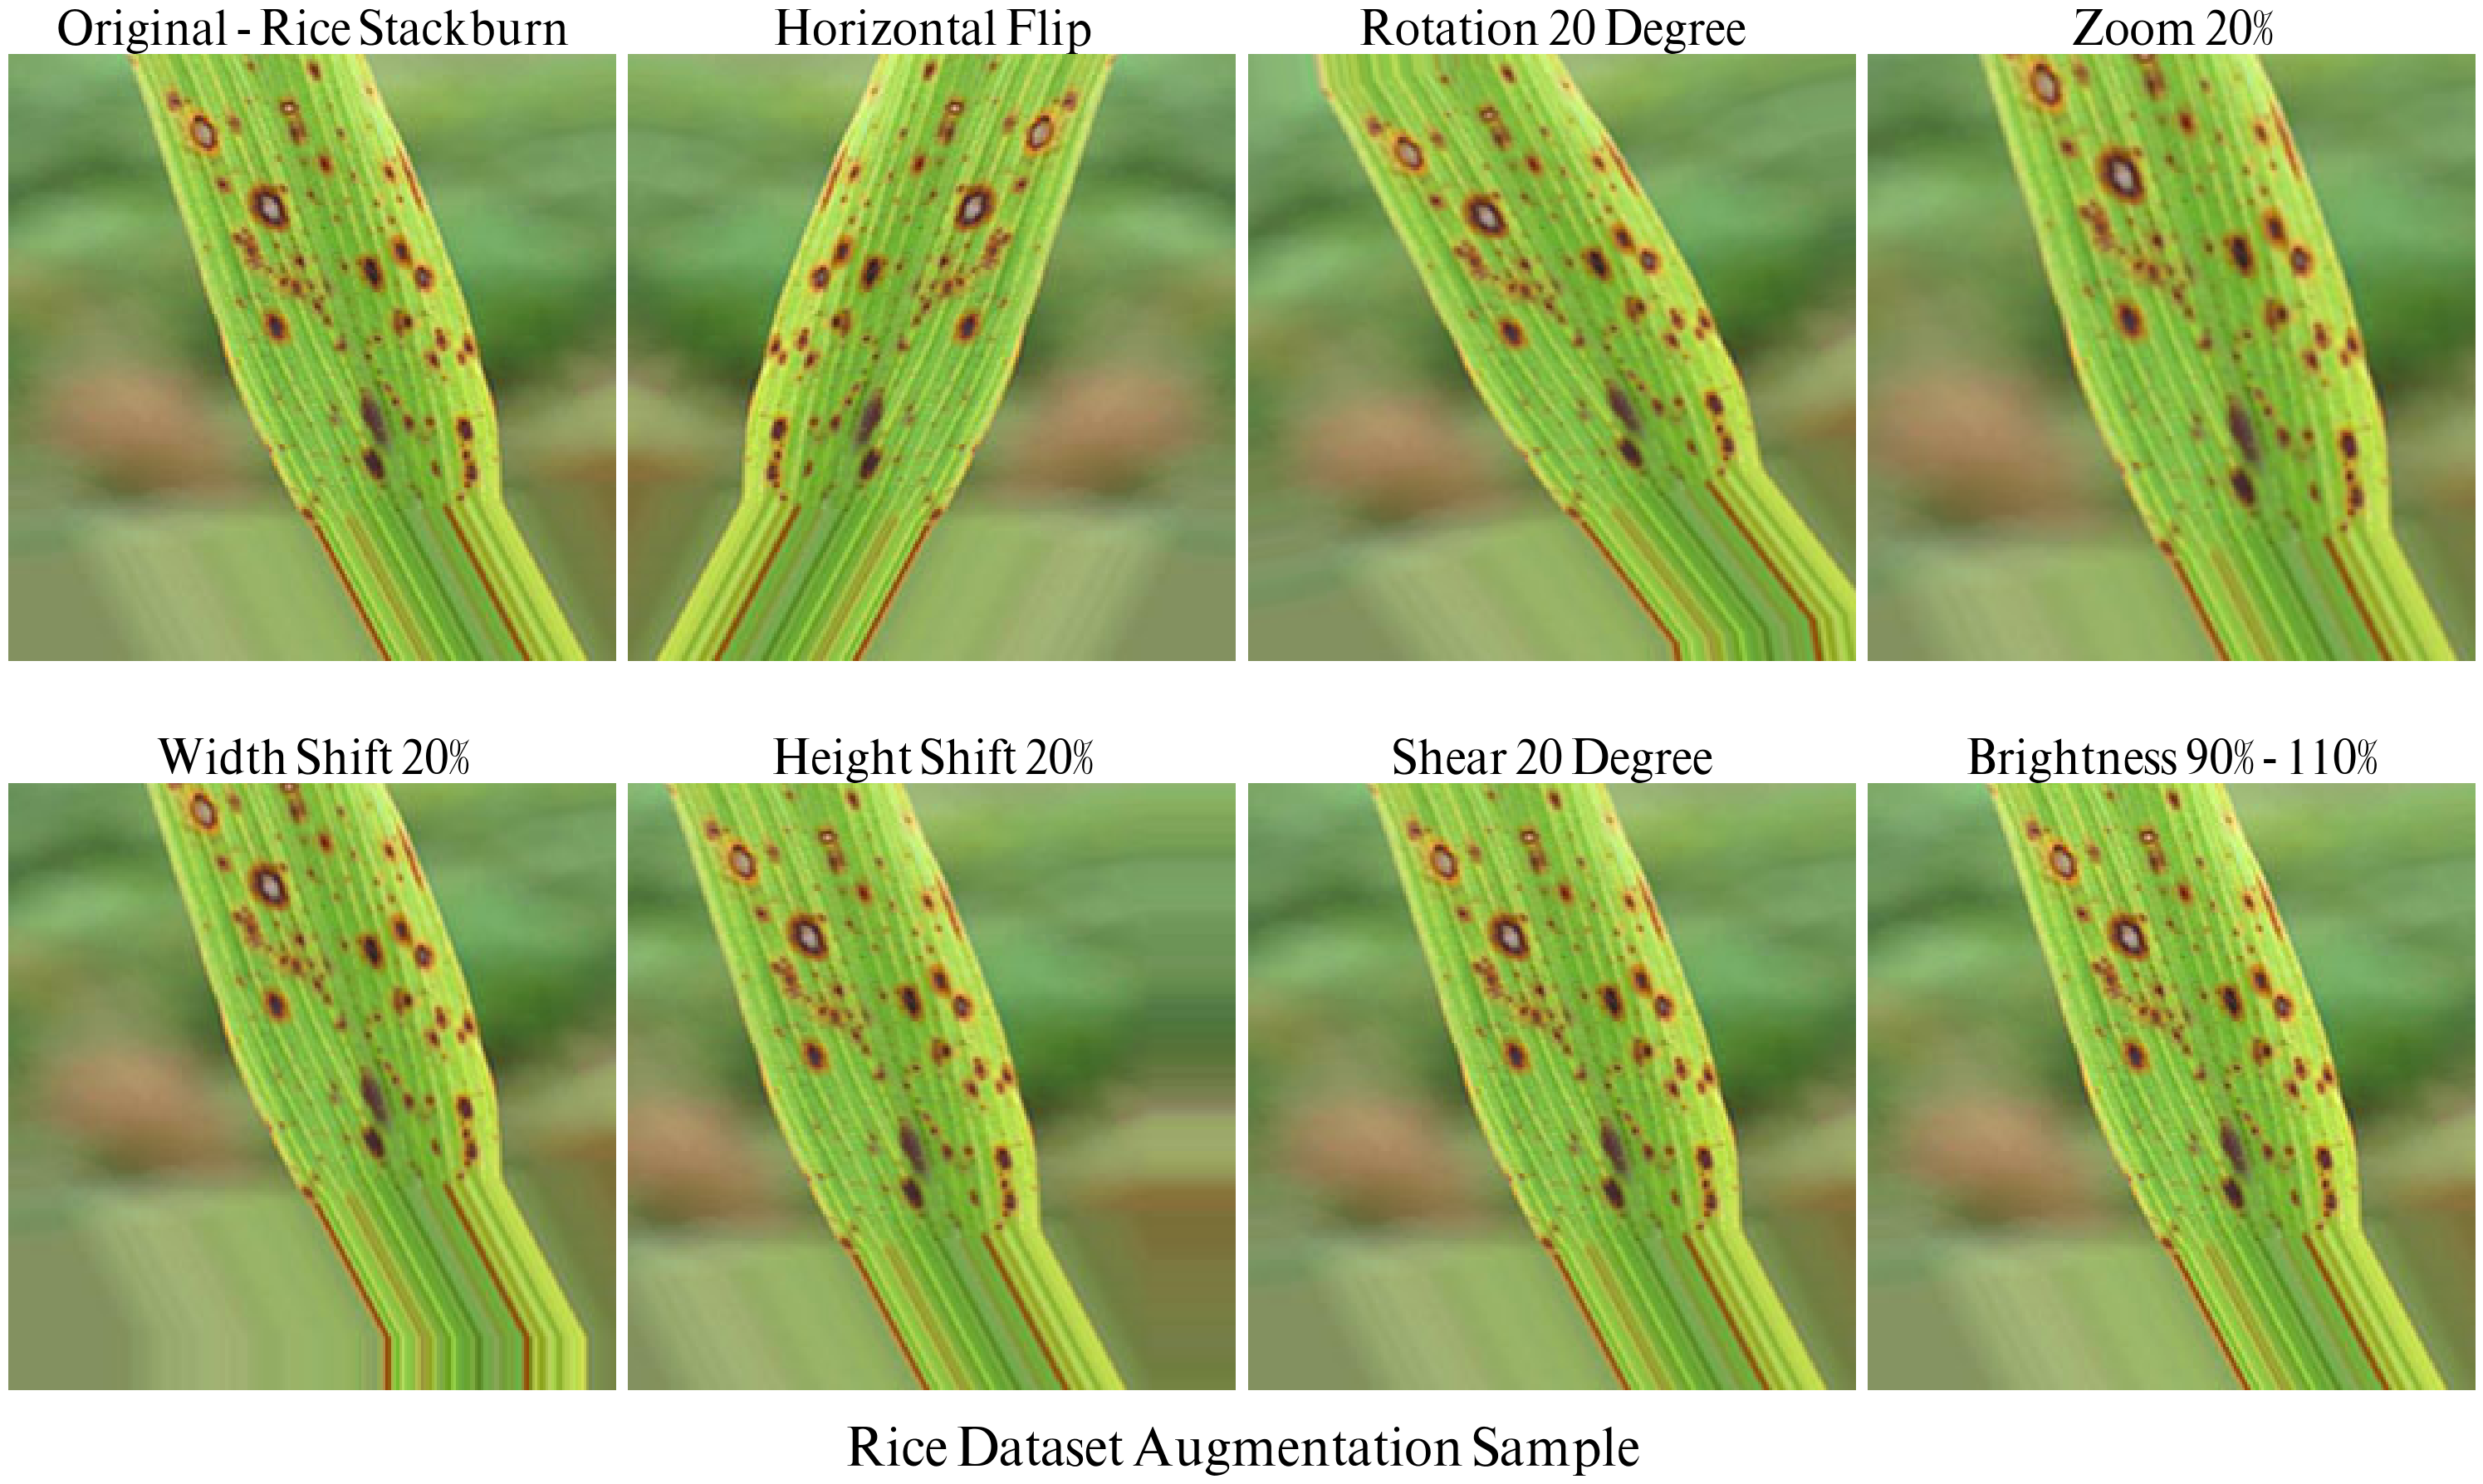

In [ ]:
preview_augmented_images(train_data, title=rice_title, index=2, paths=rice_sample_img_dir)

## **Summary of dataset**

**ส่วนที่รันเพิ่มเติม**

In [ ]:
TRAIN_DF, VALID_DF = to_dataframe_excel(path="/content/drive/MyDrive/projectPlant/DatasetSetting/riceDataset/split_data_seed_42.xlsx", sheet_name='Split-Data', mode='multi', condition=False, labels_mapping=labels_mapping)

In [ ]:
TEST_DF = to_dataframe(rice_test_dir, mode='multi', condition=False, labels_mapping=labels_mapping)

Total images: 60
Total classes: 5


In [ ]:
combined_df = pd.concat([TRAIN_DF, VALID_DF, TEST_DF], axis=0).reset_index(drop=True)
combined_df = combined_df.drop(columns=['Original_Index'])
combined_df

,Filepath,Label
0,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
1,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Smut
2,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
3,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Stackburn
4,/content/drive/MyDrive/projectPlant/riceDatase...,Rice Leaf Scald
...,...,...
555,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip
556,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip
557,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip
558,/content/drive/MyDrive/projectPlant/riceDatase...,Rice White Tip


In [ ]:
class_list = combined_df['Label'].unique().tolist()
print(class_list)

total_count = []
train_count = []
val_count = []
test_count = []

for class_name in class_list:
    total_count.append(len(combined_df[combined_df['Label'] == class_name]))
    train_count.append(len(TRAIN_DF[TRAIN_DF['Label'] == class_name]))
    val_count.append(len(VALID_DF[VALID_DF['Label'] == class_name]))
    test_count.append(len(TEST_DF[TEST_DF['Label'] == class_name]))

['Rice Stackburn', 'Rice Leaf Smut', 'Rice Leaf Scald', 'Rice White Tip', 'Bacterial Leaf Streak']


In [ ]:
summary_df = pd.DataFrame({
    'Class': class_list,
    'Dataset Count': total_count,
    'Train Count': train_count,
    'Validation Count': val_count,
    'Test Count': test_count
})
print(summary_df.to_string(index=False))

                Class  Dataset Count  Train Count  Validation Count  Test Count
       Rice Stackburn            107           61                39           7
       Rice Leaf Smut            115           79                21          15
      Rice Leaf Scald            115           68                32          15
       Rice White Tip            115           72                28          15
Bacterial Leaf Streak            108           70                30           8


In [ ]:
summary_df.to_excel(rice_excel_dir + 'summary_dataset.xlsx', index=False)